<img src="figs/NTU_logo.png" align="left" width="50" height="50" /> <br>
<h1 style="text-align:center"> XỬ LÝ DỮ LIỆU LỚN </h1>

<h1 style="text-align:center"> Lab 3: Phân tích dữ liệu thời tiết </h1>

- [Giới thiệu](#intro) <br>

- [Chương trình MapReduce ](#mapreduceprogram) <br>

- [Chạy ứng dụng trên Hadoop](#run_program) <br>
- [Bài tập](#excercises)


## Giới thiệu <a name="intro"/>

Bài thực hành này xử lý dữ liệu thu thập bởi [Trung tâm dữ liệu thời tiết Hoa Kỳ](https://www.ncdc.noaa.gov/) (NCDC). Dữ liệu được thu nhận từ các trạm quan trắc được đặt ở nhiều nơi, cung cấp các số đo về khí tượng, bao gồm: ngày, giờ, tọa độ, độ cao, nhiệt độ, áp suất không khí, hướng gió <br>
**Yêu cầu**: Từ tập dữ liệu thu thập được, hãy tìm nhiệt độ cao nhất của mỗi năm.

<p align="center">
<img src="figs/ncdc_data_sample.png" width="70%"/>
<center>
    <caption>Minh họa một mẫu dữ liệu khí tượng từ NCDC. Trong thực tế mỗi bản ghi nằm trên một dòng, các trường dữ liệu liên tiếp nhau (không có ký tự phân cách). 
    </caption>
    <em>
        Nguồn: Tom White, Hadoop: The definitive Guide, 4th Ed.
    </em>
</center>
</p>

## Chương trình MapReduce  <a name = "mapreduceprogram"/>

### Map
MapReduce xem dữ liệu vào dưới dạng các cặp <k1,v1>. Trong trường hợp này `k1` là thứ tự dòng văn bản, `v1` là chuỗi ký tự chứa 1 bản ghi dữ liệu thời tiết.
Chương trình `mapper` đọc từng dòng ký tự từ stdin, lấy ra các giá trị: năm, nhiệt độ và đưa ra stdout dưới dạng <k2,v2> = <year,temperature>.
Các cặp <k2,v2> sẽ được gộp theo `k2`, tức theo năm, trước khi gửi đến pha Reduce.

In [1]:
#!/usr/bin/python3
'''mapper.py'''

import re
import sys

# <k1, v1> = <line, text>
for line in sys.stdin:
  val = line.strip()
  (year, temp, q) = (val[15:19], val[87:92], val[92:93])
  # Nhiệt đô == "+9999" -> không có dữ liệu
  # q (quality code) == "01459" -> dữ liệu không bị lỗi
  if (temp != "+9999" and re.match("[01459]", q)):
    print("%s\t%s" % (year, temp)) # <k2, v2> = <year, temperature>

### Reduce
Chương trình reducer đọc từng dòng từ `stdin`, lấy ra từng cặp <k2, v2>. Với mỗi giá trị của `k2`, chương trình sẽ tìm giá trị lớn nhất của `v2` và đưa ra `stdout`.

In [2]:
#!/usr/bin/python3
'''reducer.py'''

import sys

(last_key, max_val) = (None, -sys.maxsize)
for line in sys.stdin:
  (key, val) = line.strip().split("\t")
  if last_key and last_key != key:
    print("%s\t%s" % (last_key, max_val))
    (last_key, max_val) = (key, int(val))
  else:
    (last_key, max_val) = (key, max(max_val, int(val)))

if last_key:
  print("%s\t%s" % (last_key, max_val))

## Chạy ứng dụng Hadoop MapReduce <a name="run_program"/>

### Khởi động Hadoop
Thực hiện lệnh sau:
```shell
start-all.sh
```

### Đưa dữ liệu lên HDFS 
Trước khi chạy chương trình MapReduce, cần đưa dữ liệu xử lý lên HDFS.

#### Tạo thư mục chứa dữ liệu trên HDFS
```shell
hdfs dfs -mkdir -p data/lab3
```
Hệ thống tạo thư mục `/user/hdoop/data/lab3` trên HDFS.
#### Đưa dữ liệu từ máy cục bộ lên HDFS
Giả sử thư mục chứa dữ liệu đầu vào là `/home/hung/Downloads/ncdc` chứa các files dữ liệu thời tiết của NCDC đã được tiền xử lý gộp theo từng năm.
Thực hiện lệnh sau để copy dữ liệu lên HDFS:
```shell
hdfs dfs -copyFromLocal /home/hung/Downloads/ncdc /user/hdoop/data/lab3
```

#### Chạy chương trình MapReduce
Giả sử 2 file `mapper.py` và `reducer.py` lưu ở thư mục `/home/hdoop/labs/lab3`.

- Chuyển dấu nhắc đến thư mục `lab3`:
```shel
cd /home/hdoop/labs/lab3
```
- Chạy ứng dụng MapReduce thông qua Hadoop Streaming:
```shell
hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-3.2.2.jar \
 -file mapper.py -mapper mapper.py \
 -file reducer.py -reducer reducer.py \
 -input /user/hdoop/data/lab3/ncdc \
 -output /user/hdoop/data/lab3/ncdc-output 
```

- Kiểm tra kết quả xử lý:
```shell
hdfs dfs -ls /user/hdoop/data/lab3/ncdc-output 
```

Copy file kết quả từ HDFS xuống máy ổ đĩa cục bộ:
```shell
hdfs dfs -copyToLocal /user/hdoop/data/lab3/ncdc-output/part-00000 .
```

### Vẽ biểu đồ kết quả xử lý

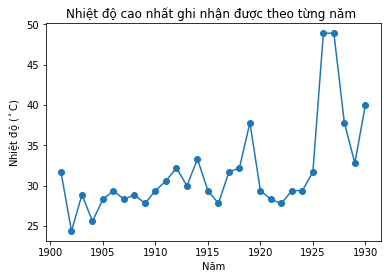

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt

# Đọc dữ liệu kết quả
max_temps = pd.read_csv('output-lamminhthien/ncdc-output.txt', delimiter='\t', header=None, names=['year', 'temp'])
# Vẽ biểu đồ 
plt.plot(max_temps['year'], max_temps['temp'] /10, marker="o")
plt.title('Nhiệt độ cao nhất ghi nhận được theo từng năm ')
plt.xlabel('Năm')
plt.ylabel('Nhiệt độ ($^\circ$C)')

plt.show()

## Bài tập <a name="excercises"/>


Từ dữ liệu NCDC đã cho, thực hiện các xử lý sau:
- Tìm nhiệt độ thấp nhất của mỗi năm.
- Tính nhiệt độ trung bình của mỗi năm.
- Tìm thời gian (ngày, giờ), tọa độ (latitude, longtitude) tương ứng với nhiệt độ cao nhất mỗi năm. 
<br>
Hướng dẫn: cho s là một dòng dữ liệu, tọa độ được tính như sau:

```python 
(lat, long) = (int(s[28:34])/1000,int(s[34:41])/1000)
```

- Tìm tên địa điểm trên trái đất tương ứng với tọa độ nóng nhất mỗi năm.
<br>

Hướng dẫn:
Có thể sử dụng gói `reverse_geocoder` để lấy địa danh từ tọa độ.

Cài đặt `reverse_geocoder`:
```shell
pip install reverse_geocoder
```
Sau đó lấy địa danh dựa theo đoạn code sau đây:

In [1]:
# Find location name given (lat, long)
# Coded by Hung Nguyen @ Nha Trang University

import reverse_geocoder as rg
import pprint
  
def Geocode2Location(coordinates):
    location = rg.search(coordinates)
    return location

f = open('data/preprocessed/1901.txt', 'r')
line = f.readline()

lat = int(line[28:34])/1000
long = int(line[34:41])/1000

geoCode = (lat, long)
result = Geocode2Location(geoCode)[0]

# use prettry printer to display result
pprint.pprint(result)

print("\nĐịa điểm quan trắc: ", result['name'] + ', ' + result['cc'])

Loading formatted geocoded file...
{'admin1': 'Central Ostrobothnia',
 'admin2': 'Kokkola',
 'cc': 'FI',
 'lat': '64.02472',
 'lon': '23.50482',
 'name': 'Lohtaja'}

Địa điểm quan trắc:  Lohtaja, FI


In [ ]:
# Find location name given (lat, long)
# Coded by Hung Nguyen @ Nha Trang University

import reverse_geocoder as rg
import pprint
  
def Geocode2Location(coordinates):
    location = rg.search(coordinates)
    return location
with open('/mnt/d/Code/Big-Data/Lab3_NCDC_WeatherData/data/data_has_weather_latlon', 'r') as f:
    temp_max_lat_lon = [for s in f.readlines()]
line = f.readline()

lat = int(line[28:34])/1000
long = int(line[34:41])/1000

geoCode = (lat, long)
result = Geocode2Location(geoCode)[0]

# use prettry printer to display result
pprint.pprint(result)

print("\nĐịa điểm quan trắc: ", result['name'] + ', ' + result['cc'])